In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
root_path = "E:\\IOAI\\kits\\neoai-2025\\tricy-table-data"
seed = 42

# Data preparation

In [ ]:
imputer = SimpleImputer(strategy="median")

def clean_df(df: pd.DataFrame, is_train: bool):
    if "target" in df:
        y = df[["target"]]
    df = df.drop(["id", "target"], axis=1, errors="ignore")

    for col in df.columns:
        df[f'{col}_is_nan'] = df[col].isna().astype(int)

    df["feat_0_l500"] = (df["feat_0"] < 500).astype(int)
    df["feat_5_l60"] = (df["feat_5"] < 60).astype(int)
    df["feat_3_l90"] = (df["feat_3"] < 90).astype(int)
    df["feat_6_l3000"] = (df["feat_6"] < 3000).astype(int)
    df["feat_7_m1000"] = (df["feat_7"] > 1000).astype(int)
    df["feat_8_m620"] = (df["feat_8"] > 620).astype(int)

    df = df.drop(["feat_3_is_nan", "feat_2_is_nan", "feat_2", "feat_0_is_nan", "minute_is_nan"], axis=1, errors="ignore")
    num_cols = df.select_dtypes(include="number").columns.tolist()

    if is_train:
        df[num_cols] = imputer.fit_transform(df[num_cols])
        y = np.log(y)
        return df, y

    df[num_cols] = imputer.transform(df[num_cols])
    return df

In [134]:
df = pd.read_csv(f"{root_path}\\train_tables.csv")
X, y = clean_df(df, is_train=True)

In [135]:
X.head()

,feat_0,feat_1,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,day,hour,...,feat_7_is_nan,feat_8_is_nan,day_is_nan,hour_is_nan,feat_0_l500,feat_5_l60,feat_3_l90,feat_6_l3000,feat_7_m1000,feat_8_m620
0,470.933685,2563.308124,87.061722,2854.097632,52.455972,2744.457436,1331.064839,653.024118,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,322.752334,1706.970061,84.277867,2962.979989,41.355108,1690.248184,1198.654829,636.739861,2.0,10.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,437.018615,2488.229729,83.672355,2873.775118,48.856837,2441.896999,1319.009963,651.866006,1.0,10.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,286.164002,2563.308124,73.363886,2947.575123,37.927285,1487.642316,1139.463820,538.749367,2.0,16.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,437.593246,2481.820613,82.674960,2836.678634,49.831503,2428.457628,1321.312742,642.256715,1.0,12.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


# EDA

In [136]:
df.isna().sum().sort_values(ascending=False)

feat_7    4740
day       4651
feat_5    4628
feat_3    4585
feat_2    4482
feat_6    4406
feat_8    4297
hour      4275
feat_0    3616
feat_4    3601
minute    3528
feat_1    3479
target       0
dtype: int64

In [137]:
corrs = X.corrwith(y["target"]).sort_values(ascending=True)
corrs

feat_4          -0.660773
day             -0.463356
feat_0_l500     -0.146900
hour            -0.104126
feat_6_is_nan   -0.009487
feat_5_is_nan   -0.008656
feat_7_is_nan   -0.004849
feat_1_is_nan   -0.004486
hour_is_nan     -0.003970
feat_3_l90       0.002538
feat_8_is_nan    0.003371
day_is_nan       0.004200
feat_4_is_nan    0.007950
feat_5_l60       0.008071
feat_6_l3000     0.010028
minute           0.020135
feat_7_m1000     0.057164
feat_8_m620      0.282396
feat_7           0.306316
feat_5           0.637556
feat_3           0.640681
feat_0           0.645828
feat_6           0.649323
feat_8           0.676476
feat_1           0.927603
dtype: float64

<Axes: >

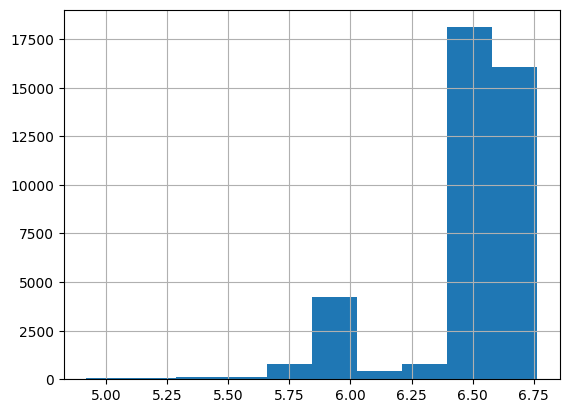

In [138]:
y["target"].hist()

# Model Selection

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [140]:
def evaluate(model):
    y_pred = model.predict(X_test)
    return root_mean_squared_error(y_test, y_pred) ** (1/4)

In [141]:
param = {
    "learning_rate": 0.1,
    "num_leaves": 48,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "min_data_in_leaf": 100,
    "objective": "mae",
    "verbosity": -1,
}

In [142]:
train_dataset = lgb.Dataset(X_train, y_train)

bst = lgb.train(param, train_dataset, num_boost_round=500)
evaluate(bst)

0.3628047524841188

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

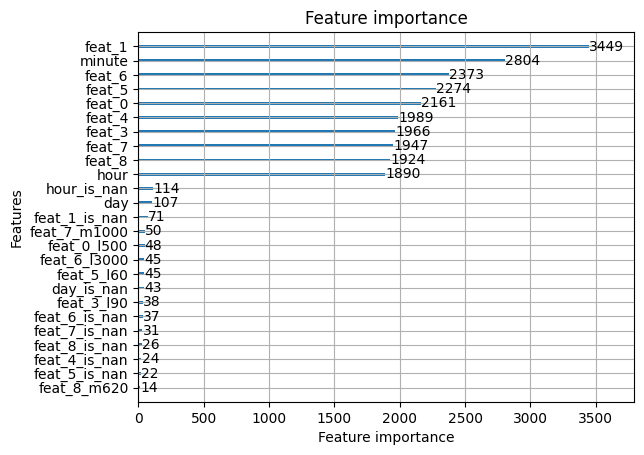

In [143]:
lgb.plot_importance(bst)

# Submission

In [144]:
def clf_train(
    train, test, target, weight_col, id_col, name_file: str, func_inv=None
):
    predict_test = np.zeros(len(test))

    tr = lgb.Dataset(train, target, weight=weight_col)
    bst = lgb.train(param, tr, num_boost_round=500)

    predict_test = bst.predict(test)
    if func_inv:
        predict_test = func_inv(predict_test)

    sub = pd.DataFrame()
    sub["id"] = id_col
    sub["target"] = predict_test
    sub.to_csv(name_file, index=None)

In [145]:
df_test = pd.read_csv(f"{root_path}\\test_tables.csv")
X_test = clean_df(df_test, is_train=False)

In [146]:
drop_cols = ["target"]
weight = np.ones(len(df))
test_sub = clf_train(
    X,
    X_test,
    y,
    weight,
    df_test["id"].tolist(),
    "submission.csv",
    func_inv=np.exp,
)